In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [2]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'full_midlevel'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

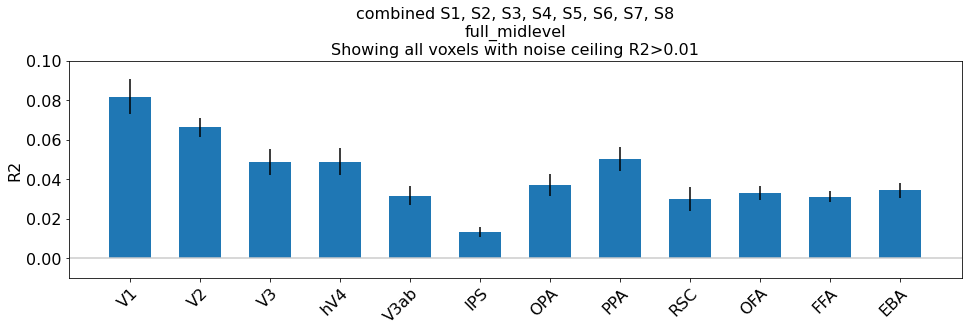

In [4]:
plt.rcParams['pdf.fonttype']=42
summary_plots.barplot_R2_all(fitting_type, out, roi_def, ylims=[-0.01, 0.10])
fn2save = '/user_data/mmhender/imStat/figures/full_midlevel_alone.pdf'
plt.savefig(fn2save)

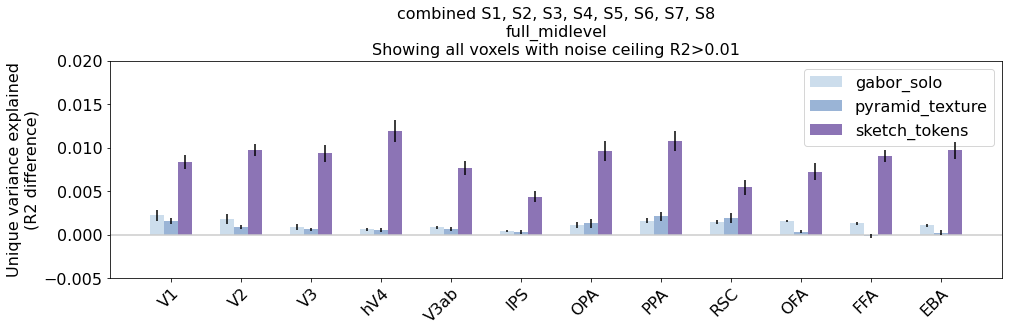

In [15]:
# Make a barplot for variance partition across all ROIs and subjects

nc_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,4,10]
ve_names = [out[0]['partial_version_names'][pp].split('leave_out_')[1] for pp in ppinds]

# colors = cm.Purples(np.linspace(0,1,6))[1:4,:]
colors = cm.BuPu(np.linspace(0,1,6))[1:4,:]

vals = np.zeros((n_subjects, n_rois, 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    
    unique_var = np.tile(val_r2[:,0:1], [1,3]) - val_r2[:,ppinds]
    var_expl = unique_var
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.2, \
                xticklabels=roi_names, ylabel='Unique variance explained\n(R2 difference)', \
                ylim=[-0.005, 0.020], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

fn2save = '/user_data/mmhender/imStat/figures/full_midlevel_varpart.pdf'
plt.savefig(fn2save)

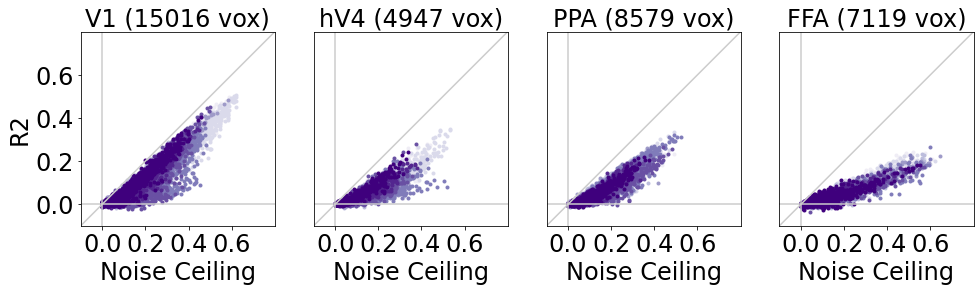

In [16]:
# Make a few scatter plots of single voxels

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

# just plot a few ROIs, because these will create very big files
rois2plot = [0, 3, 7, 10]

# concat all voxels
voxel_ncsnr = np.concatenate([o['voxel_ncsnr'][o['voxel_index']] for o in out], axis=0)
val_r2 = np.concatenate([o['val_r2'][:,0] for o in out], axis=0)

# color diff subjects differently
n_subs = len(out)
n_vox_each = np.array([o['val_r2'].shape[0] for o in out])
subject_inds = np.repeat(np.arange(n_subs), n_vox_each)

sub_colors = cm.Purples(np.linspace(0,1,n_subs+1))[1:,:]

noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
dat2plot = np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1)
inds2use = np.ones(np.shape(val_r2))==1
axlims = [-0.1, 0.8]
sp = plot_utils.scatter_plot(color=sub_colors, xlabel='Noise Ceiling', ylabel='R2', \
                                 xlims=axlims, ylims=axlims, \
                                 xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                 show_diagonal=True, show_axes=True);
plt.figure(figsize=(16,4))
plot_utils.set_all_font_sizes(24)
for ri, rr in enumerate(rois2plot):
    
    plt.subplot(1,4,ri+1)
    inds_this_roi = roi_def.get_indices(rr)
    data_this_roi = dat2plot[inds2use & inds_this_roi,:]
    subject_inds_this_roi = subject_inds[inds2use & inds_this_roi]

    sp.create(data_this_roi, new_fig=False, minimal_labels=False, \
                                      subject_inds=subject_inds_this_roi)
    if ri>0:
        plt.ylabel('')
        plt.yticks([])
        
    plt.title('%s (%d vox)'%(roi_names[rr], data_this_roi.shape[0]))
        
fn2save = '/user_data/mmhender/imStat/figures/combined_midlevel_r2_vs_nc.pdf'
plt.savefig(fn2save)

['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens']
[791, 838, 295, 737]
[96, 49, 592, 150]


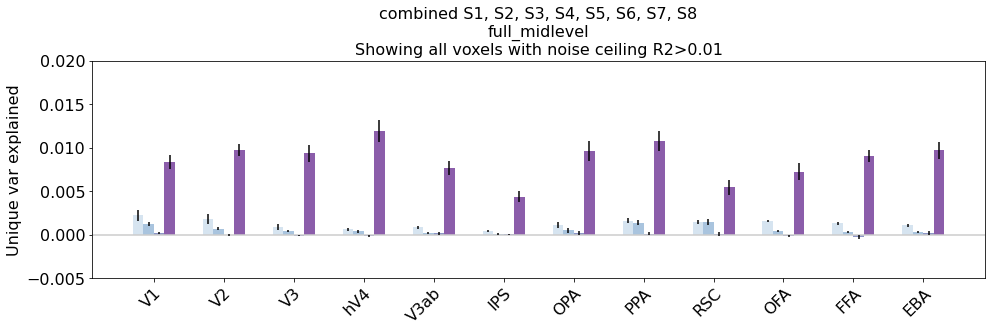

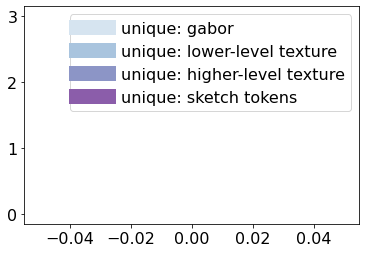

In [ ]:
# Same thing, but separating the two types of pyramid features.

nc_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens']

colors = cm.BuPu(np.linspace(0,1,7))[1:5,:]

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
  
    var_expl = np.tile(val_r2[:,0:1], [1,4]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.1, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.005, 0.020], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


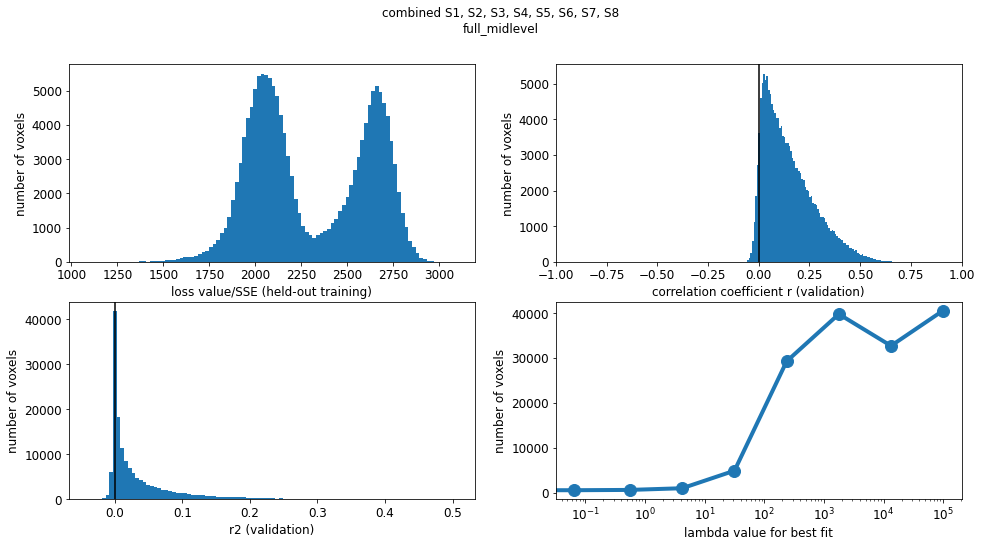

In [22]:
# more summary plots
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(fitting_type, out)

In [26]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_summary_pycortex(fitting_type, out, port=44442, roi_def=roi_def)

navigate browser to: 127.0.0.1:44442
Started server on port 44442
Stopping server


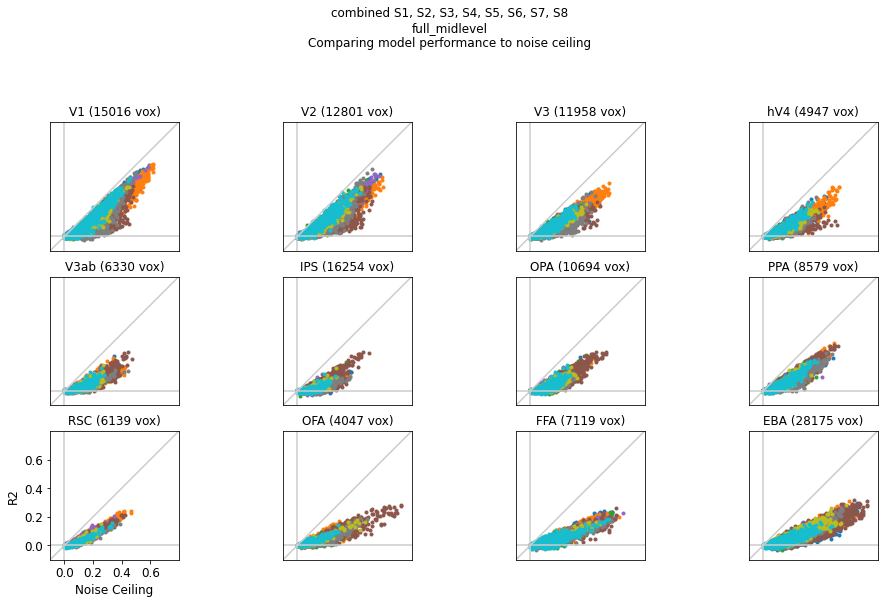

In [ ]:

plot_utils.set_all_font_sizes(fs = 12)

group_color_inds = np.repeat(np.arange(n_subs), n_vox_each)
    
    
